# Neural Style Transfer

**Neural style transfer** is an optimization tecnique used to take a content image and a style image and blend them together. So, the output image looks like the content image but painted in the style of the style image.

  "Generate artistic style image which retains the content and style features"

## Import Libraries and VGG Pre-trained model

In [1]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/shreyasi/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Freeze the layers of the VGG19 model to avoid gradient computations during training

In [3]:
for parameters in vgg.parameters():
    parameters.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess Images

In [8]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    # Resize the image
    img_transforms = T.Compose([T.Resize(size), 
                                T.ToTensor(), 
                                T.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])])
    
    image = img_transforms(image)
    
    image = image.unsqueeze(0)  # (3, 224, 224) -> (1, 3, 224, 224)
    
    return image

In [9]:
content_pre = preprocess('./Images/content2.jpg')
style_pre = preprocess('./Images/style3.jpg')

In [10]:
print("Content Shape", content_pre.shape)
print("Style Shape", style_pre.shape)

Content Shape torch.Size([1, 3, 259, 345])
Style Shape torch.Size([1, 3, 625, 500])


## Deprocess Images

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
    image = tensor.clone()
    image = image.numpy()
    
    image = image.squeeze(0)  # (1, 3, 224, 224) -> (3, 224, 224)
    image = image.transpose(1,2,0)
    
    # De-normalize image
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image.clip(0, 1)
    
    return image

In [14]:
content_de = deprocess(content_pre)
style_de = deprocess(style_pre)

print("Deprocessed Content Shape", content_de.shape)
print("Deprocessed Style Shape", style_de.shape)

Deprocessed Content Shape (259, 345, 3)
Deprocessed Style Shape (625, 500, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


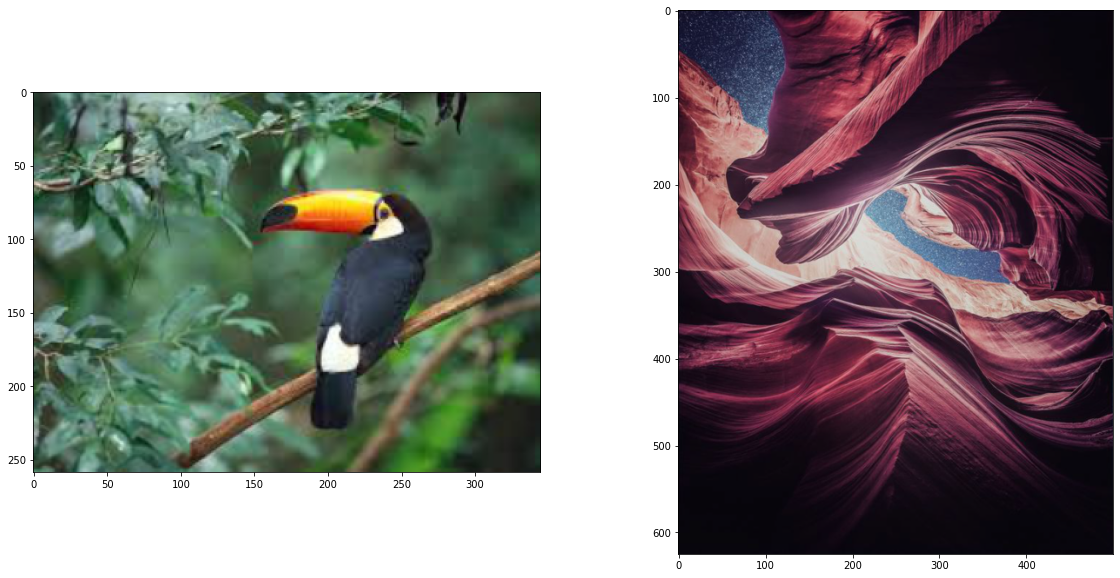

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content_de)
ax2.imshow(style_de)

## Get content, style features and create gram matrix

In [16]:
def get_features(image, model):
    layers = {'0' : 'conv1_1', 
              '5' : 'conv2_1', 
              '10' : 'conv3_1', 
              '19' : 'conv4_1', 
              '21' : 'conv4_2', 
              '28' : 'conv5_1'}
    
    x = image
    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

In [17]:
content_f = get_features(content_pre, vgg)
style_f = get_features(style_pre, vgg)

### Gram Matrix - Correlation between the filters

In [18]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    return gram

In [19]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

print(style_grams)

{'conv1_1': tensor([[  6591.3452,   4106.3496,   4337.9424,  ...,    551.7059,
           1967.9061,   4242.2822],
        [  4106.3496, 181579.7344,   3408.6570,  ...,  31295.2402,
          45135.5195,  74811.1641],
        [  4337.9424,   3408.6570,   5252.0410,  ...,    232.3348,
           2553.4128,   5760.7515],
        ...,
        [   551.7059,  31295.2402,    232.3348,  ...,  60120.3516,
          34935.0703,  30554.0645],
        [  1967.9061,  45135.5195,   2553.4128,  ...,  34935.0703,
          61426.7109,  38730.9531],
        [  4242.2822,  74811.1641,   5760.7515,  ...,  30554.0645,
          38730.9531,  75924.8984]]), 'conv2_1': tensor([[123408.7891,  14582.1895,  91896.4766,  ...,   3909.2134,
          22226.9219,  34196.8125],
        [ 14582.1895,  82467.6641,  45438.9844,  ...,  12178.8877,
          34635.3164,  21845.1230],
        [ 91896.4766,  45438.9844, 288160.9688,  ...,  23880.2500,
          11055.7920,  46387.5039],
        ...,
        [  3909.2131, 

## Get Content and Style Loss

In [27]:
def content_loss(target_conv4_2, content_conv4_2):
    loss = torch.mean((target_conv4_2 - content_conv4_2) ** 2)
    return loss

In [28]:
style_weights = {'conv1_1' : 1.0, 
                 'conv2_1' : 0.75, 
                 'conv3_1' : 0.2, 
                 'conv4_1' : 0.2, 
                 'conv5_1' : 0.2}

def style_loss(style_weights, target_features, style_grams):
    loss = 0
    
    for layer in style_weights:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]
        b, c, h, w = target_f.shape
        
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss / (c * h * w)
        
    return loss

In [29]:
target = content_pre.clone().requires_grad_(True)
target_f = get_features(target, vgg)

print("Content Loss : ", content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("Style Loss : ", style_loss(style_weights, target_f, style_grams))

Content Loss :  tensor(0., grad_fn=<MeanBackward0>)
Style Loss :  tensor(1790.8411, grad_fn=<AddBackward0>)


## Training Loop

In [30]:
from torch import optim

optimizer = optim.Adam([target], lr = 0.003)
alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [33]:
def total_loss(c_loss, s_loss, alpha, beta):
    loss = alpha * c_loss + beta * s_loss
    return loss

In [35]:
results = []

for i in range(epochs):
    target_f = get_features(target, vgg)
    c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
    s_loss = style_loss(style_weights, target_f, style_grams)
    t_loss = total_loss(c_loss, s_loss, alpha, beta)
    
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    
    if i % show_every == 0:
        print(f"Total Loss at Epoch {i} : {t_loss}")
        results.append(deprocess(target.detach()))

Total Loss at Epoch 0 : 178333968.0
Total Loss at Epoch 500 : 27048898.0
Total Loss at Epoch 1000 : 15128838.0
Total Loss at Epoch 1500 : 11668925.0
Total Loss at Epoch 2000 : 9606220.0
Total Loss at Epoch 2500 : 8200488.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


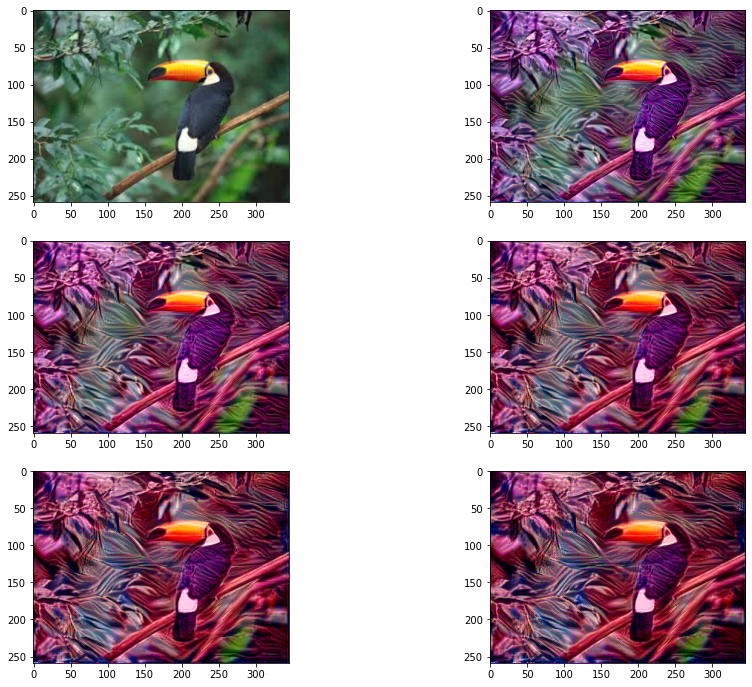

In [48]:
plt.figure(figsize = (15, 12))

for i in range(len(results)):
    plt.subplot(3, 2, i + 1)
    plt.imshow(results[i])
    
    plt.savefig(f'./Outputs/output{i+1}.jpg')
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


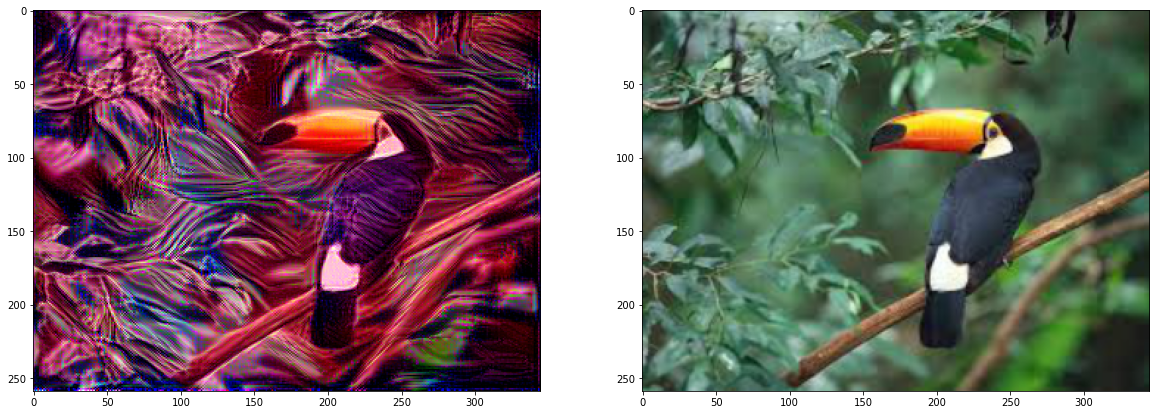

In [51]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_pre)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
plt.savefig('./Outputs/output7.jpg')